Processing sample 1/30
Processing sample 2/30
Processing sample 3/30
Processing sample 4/30
Processing sample 5/30
Processing sample 6/30
Processing sample 7/30
Processing sample 8/30
Processing sample 9/30
Processing sample 10/30
Processing sample 11/30
Processing sample 12/30
Processing sample 13/30
Processing sample 14/30
Processing sample 15/30
Processing sample 16/30
Processing sample 17/30
Processing sample 18/30
Processing sample 19/30
Processing sample 20/30
Processing sample 21/30
Processing sample 22/30
Processing sample 23/30
Processing sample 24/30
Processing sample 25/30
Processing sample 26/30
Processing sample 27/30
Processing sample 28/30
Processing sample 29/30
Processing sample 30/30


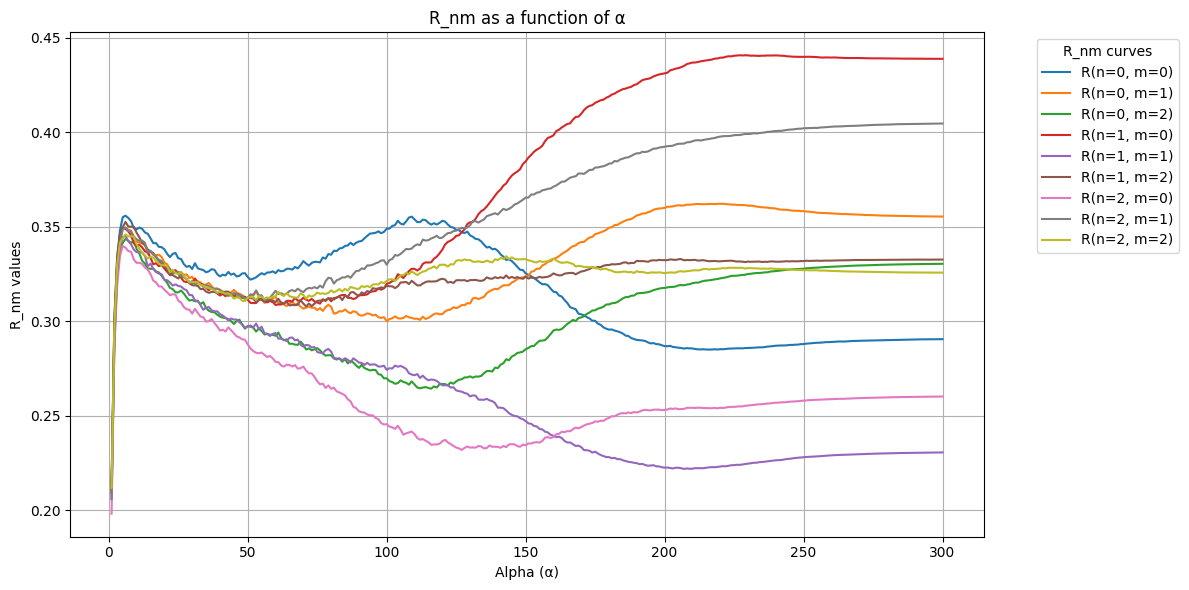

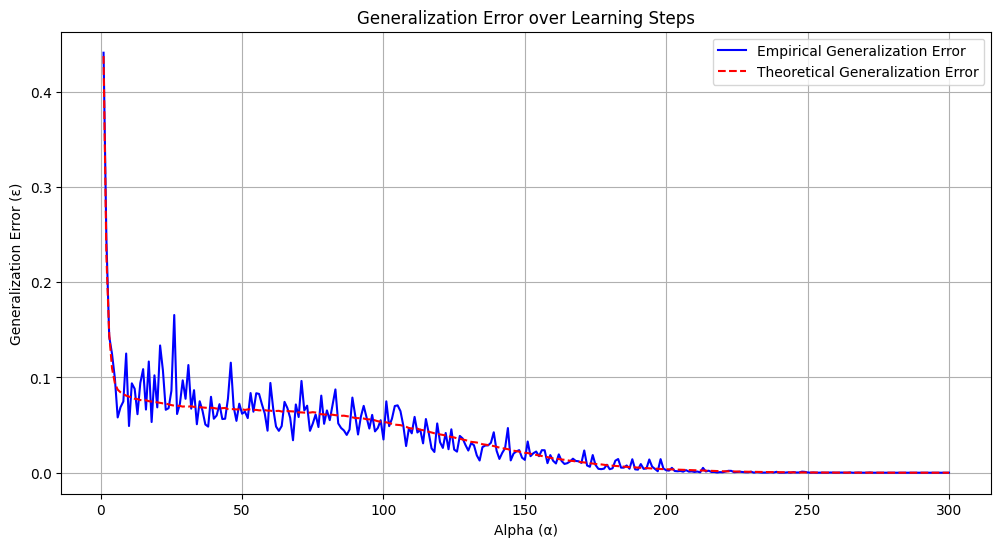

In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(338)

# Parameter settings
N = 1000
hidden_units = 3
samples = 30
learning_rate = 1 / N  # Learning rate
alpha_steps = 300
total_steps = alpha_steps * N  # Total steps for online learning

# Activation function and its derivative
def g(x):
    return erf(x / np.sqrt(2))

def g_dot(x):
    return (np.sqrt(2) / np.sqrt(np.pi)) * np.exp(-x**2 / 2)

# Teacher output function
def teacher_output(B, epsilon):
    y = np.dot(B, epsilon)
    g_y = g(y)
    sigma_y = np.sum(g_y)
    return sigma_y, g_y, y

# Student output function
def student_output(J, epsilon):
    x = np.dot(J, epsilon)
    g_x = g(x)
    sigma_x = np.sum(g_x)
    return sigma_x, g_x, x

# Compute overlap matrices
def compute_overlaps(J, B):
    R = np.dot(J, B.T)
    Q = np.dot(J, J.T)
    T = np.dot(B, B.T)
    return Q, R, T

# Compute theoretical error
def theoretical_error(Q, R, T):
    hidden_units = Q.shape[0]
    sum_Q = np.sum([np.arcsin(Q[i, k] / np.sqrt((1 + Q[i, i]) * (1 + Q[k, k])))
                    for i in range(hidden_units) for k in range(hidden_units)])
    sum_T = np.sum([np.arcsin(T[n, m] / np.sqrt((1 + T[n, n]) * (1 + T[m, m])))
                    for n in range(hidden_units) for m in range(hidden_units)])
    sum_R = np.sum([np.arcsin(R[i, n] / np.sqrt((1 + Q[i, i]) * (1 + T[n, n])))
                    for i in range(hidden_units) for n in range(hidden_units)])
    theor_error = (1 / np.pi) * (sum_Q + sum_T - 2 * sum_R)
    return theor_error

# Online learning function
def online_learning(B, J, steps, eval_interval):
    errors = []
    theoretical_errors = []
    R_values = []
    for t in range(steps):
        # Generate input vector
        epsilon = np.random.normal(0, 1, N)

        # Compute teacher and student outputs
        sigma_y, g_y, y = teacher_output(B, epsilon)
        sigma_x, g_x, x = student_output(J, epsilon)
        delta = sigma_y - sigma_x

        # Update student weights
        g_dot_x = g_dot(x)
        delta_J = learning_rate * g_dot_x[:, np.newaxis] * delta * epsilon
        J += delta_J

        # Periodically evaluate and store results
        if (t + 1) % eval_interval == 0:
            errors.append(0.5 * delta**2)
            Q, R, T = compute_overlaps(J, B)
            theor_error = theoretical_error(Q, R, T)
            theoretical_errors.append(theor_error)
            R_values.append(R.copy())

    return errors, theoretical_errors, R_values

# Main program
eval_interval = 1000  # Evaluate every 1000 steps
eval_points = total_steps // eval_interval

# Arrays to store results from different samples
R_samples = np.zeros((samples, eval_points, hidden_units, hidden_units))
generalization_errors_samples = np.zeros((samples, eval_points))
theoretical_errors_samples = np.zeros((samples, eval_points))

for sample in range(samples):
    print(f"Processing sample {sample + 1}/{samples}")

    # Initialize teacher and student weights
    B = np.random.normal(0, np.sqrt(1 / N), (hidden_units, N))
    J = np.random.normal(0, np.sqrt(1 / N), (hidden_units, N))

    # Perform online learning
    errors, theoretical_errors, R_values = online_learning(B, J, total_steps, eval_interval)

    # Store results
    generalization_errors_samples[sample] = errors
    theoretical_errors_samples[sample] = theoretical_errors
    R_samples[sample] = R_values

# Compute averages
average_R_nm = np.mean(R_samples, axis=0)
average_generalization_errors = np.mean(generalization_errors_samples, axis=0)
average_theoretical_errors = np.mean(theoretical_errors_samples, axis=0)

# Plot R_nm as a function of alpha
alphas = np.arange(1, eval_points + 1) * eval_interval / N  # Convert steps to alpha
plt.figure(figsize=(12, 6))
for n in range(hidden_units):
    for m in range(hidden_units):
        plt.plot(alphas, average_R_nm[:, n, m], label=f'R(n={n}, m={m})')
plt.title('R_nm as a function of α')
plt.xlabel('Alpha (α)')
plt.ylabel('R_nm values')
plt.legend(title='R_nm curves', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Plot generalization error over learning steps
plt.figure(figsize=(12, 6))
plt.plot(alphas, average_generalization_errors, label='Empirical Generalization Error', color='blue')
plt.plot(alphas, average_theoretical_errors, label='Theoretical Generalization Error', color='red', linestyle='dashed')
plt.title('Generalization Error over Learning Steps')
plt.xlabel('Alpha (α)')
plt.ylabel('Generalization Error (ε)')
plt.legend()
plt.grid()
plt.show()